In [ ]:
import tensorflow as tf
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
    #link google drive with colab for accessing training/test data and saving checkpoints
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
    root="/content/drive/My Drive/projects/captions"

Mounted at /content/drive
Note: using Google CoLab


Load document containing images and corresponding 5 captions in memory

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = os.path.join(root,"Flickr8k_text/Flickr8k.token.txt")
# load descriptions
doc = load_doc(filename)
print(doc[:100])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


Create a mapping from image name to its 5 captions

In [ ]:
# dictionary created using image id as key and list of its captions as values
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id i.e remove the .jpg extension
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
list(descriptions.keys())[0]

'1000268201_693b08cb0e'

In [ ]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = os.path.join(root,"Flickr8k_text/Flickr_8k.trainImages.txt")
train = load_set(filename)
print('Dataset: %d' % len(train))
# train

Dataset: 6000


In [ ]:
# Below path contains all the images
images_test =os.path.join(root,"pics/")
images_train =os.path.join(root,"Flicker8k_Dataset/")
# Create a list of all image names in the directory
img_test = glob.glob(images_test + '*.jpg')
# img_train = glob.glob(images_train + '*.jpg')
# len(img_train)
img_test

['/content/drive/My Drive/projects/captions/pics/test.jpg',
 '/content/drive/My Drive/projects/captions/pics/Copy of 3744832122_2f4febdff6.jpg',
 '/content/drive/My Drive/projects/captions/pics/Copy of 3737711435_113ccd0a52.jpg',
 '/content/drive/My Drive/projects/captions/pics/Copy of 3727752439_907795603b.jpg',
 '/content/drive/My Drive/projects/captions/pics/Copy of 3726730085_2468ee9220.jpg']

In [ ]:


# Below file conatains the names of images to be used in train data
# train_images_file = os.path.join(root,"Flickr8k_text/Flickr_8k.trainImages.txt")
# Read the train image names in a set
# train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# # Create a list of all the training images with their full path names
# train_img = []

# for i in img_train: # img is list of full path names of all images
    # if i[len(images_train):] in train_images: # Check if the image belongs to training set
#         train_img.append(i) # Add it to the list of train images
# train_img[0]
# len(train_img)

In [ ]:
# Below file conatains the names of images to be used in test data
# test_images_file = os.path.join(root,"Flickr8k_text/Flickr_8k.testImages.txt")
# Read the validation image names in a set# Read the test image names in a set
# test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
# test_img = []

# for i in img: # img is list of full path names of all images
#     if i[len(images):] in test_images: # Check if the image belongs to test set
#         test_img.append(i) # Add it to the list of test images
# test_img[0]
test_img=[]
for i in img_test:
  test_img.append(i)
test_img

['/content/drive/My Drive/projects/captions/pics/test.jpg',
 '/content/drive/My Drive/projects/captions/pics/Copy of 3744832122_2f4febdff6.jpg',
 '/content/drive/My Drive/projects/captions/pics/Copy of 3737711435_113ccd0a52.jpg',
 '/content/drive/My Drive/projects/captions/pics/Copy of 3727752439_907795603b.jpg',
 '/content/drive/My Drive/projects/captions/pics/Copy of 3726730085_2468ee9220.jpg']

In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = tf.keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Load the inception v3 model
model1 = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 3s 0us/step


In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model1.input, model1.layers[-2].output)

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
#
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_train):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
#
# Save the bottleneck train features to disk
import pickle
with open(os.path.join(root,"Pickle/encoded_train_images10.pkl"), "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    print(img)
    encoding_test[img[len(images_test):]] = encode(img)
print("Time taken in seconds =", time()-start)

/content/drive/My Drive/projects/captions/pics/test.jpg
/content/drive/My Drive/projects/captions/pics/Copy of 3744832122_2f4febdff6.jpg
/content/drive/My Drive/projects/captions/pics/Copy of 3737711435_113ccd0a52.jpg
/content/drive/My Drive/projects/captions/pics/Copy of 3727752439_907795603b.jpg
/content/drive/My Drive/projects/captions/pics/Copy of 3726730085_2468ee9220.jpg
Time taken in seconds = 4.097449541091919


In [ ]:
# Save the bottleneck test features to disk
import pickle
with open(os.path.join(root,"Pickle/encoded_test_images_copy1.pkl"), "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [ ]:
#
train_features = load(open(os.path.join(root,"Pickle/encoded_train_images.pkl"), "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=5965


In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
          if key+'.jpg' in train_features:
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            print(key)
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# Load Glove vectors
glove_dir = os.path.join(root,"glove.6B")
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1652, 200)

![alt text](https://drive.google.com/file/d/1RcrYrAp623WO9w2_zQ0j4LsQ70AYmiq0/view?usp=sharing)

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # model.save('./model_weights/model1_' + str(i) + '.h5')

Streaming output truncated to the last 5000 lines.
 334/2000 [====>.........................] - ETA: 2:26 - loss: 2.72182277081067_d2b4c98bce
2277299634_e14bdb7ff7
2278110011_ba846e7795
 335/2000 [====>.........................] - ETA: 2:26 - loss: 2.72352278766574_f71f1704a8
2278776373_fe499a93be
2279496715_8ef3ee6edb
 336/2000 [====>.........................] - ETA: 2:26 - loss: 2.72442279945145_8815c59217
2279980395_989d48ae72
2280354512_c0d035d53f
 337/2000 [====>.........................] - ETA: 2:26 - loss: 2.72362281006675_fde04e93dd
2281054343_95d6d3b882
2281075738_230892b241
 338/2000 [====>.........................] - ETA: 2:26 - loss: 2.72362281768510_9cc5728c55
2282043629_91b7831352
2282260240_55387258de
 339/2000 [====>.........................] - ETA: 2:26 - loss: 2.72222282600972_c22d1e03c7
2282895743_f803f1cf01
2284239186_c827f4defa
 340/2000 [====>.........................] - ETA: 2:26 - loss: 2.72032284894733_b710b9b106
2285152690_3fb93f65f1
2285741931_07159a21f2
 341

In [ ]:
 model.save(os.path.join(root,'model_weights/model100') + str(i) + '.h5')

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # model.save('./model_weights/model_' + str(i) + '.h5')

Streaming output truncated to the last 5000 lines.
 334/2000 [====>.........................] - ETA: 2:34 - loss: 2.52242277081067_d2b4c98bce
2277299634_e14bdb7ff7
2278110011_ba846e7795
 335/2000 [====>.........................] - ETA: 2:34 - loss: 2.52372278766574_f71f1704a8
2278776373_fe499a93be
2279496715_8ef3ee6edb
 336/2000 [====>.........................] - ETA: 2:34 - loss: 2.52462279945145_8815c59217
2279980395_989d48ae72
2280354512_c0d035d53f
 337/2000 [====>.........................] - ETA: 2:34 - loss: 2.52432281006675_fde04e93dd
2281054343_95d6d3b882
2281075738_230892b241
 338/2000 [====>.........................] - ETA: 2:33 - loss: 2.52432281768510_9cc5728c55
2282043629_91b7831352
2282260240_55387258de
 339/2000 [====>.........................] - ETA: 2:33 - loss: 2.52262282600972_c22d1e03c7
2282895743_f803f1cf01
2284239186_c827f4defa
 340/2000 [====>.........................] - ETA: 2:33 - loss: 2.52072284894733_b710b9b106
2285152690_3fb93f65f1
2285741931_07159a21f2
 341

In [ ]:
#
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

Streaming output truncated to the last 5000 lines.
133905560_9d012b47f3
  70/2000 [>.............................] - ETA: 3:11 - loss: 2.28231341787777_4f1ebb1793
1342766791_1e72f92455
1342780478_bacc32344d
  71/2000 [>.............................] - ETA: 3:11 - loss: 2.28661346529555_e916816cfe
1347519824_e402241e4f
1348113612_5bfc5f429e
  72/2000 [>.............................] - ETA: 3:11 - loss: 2.29441348891916_ebd4413033
134894450_dadea45d65
1348947380_14f0fc1237
  73/2000 [>.............................] - ETA: 3:11 - loss: 2.29871348957576_c4a78eb974
1350948838_fdebe4ff65
1351315701_6580b51c41
  74/2000 [>.............................] - ETA: 3:12 - loss: 2.29001351764581_4d4fb1b40f
1352398363_9cc8ffcce9
1354318519_2f9baed754
  75/2000 [>.............................] - ETA: 3:12 - loss: 2.29381355450069_c0675b0706
1355703632_5683a4b6fb
1355833561_9c43073eda
  76/2000 [>.............................] - ETA: 3:12 - loss: 2.29501355945307_f9e01a9a05
1356543628_c13ebe38fb
135768

In [ ]:
model.save_weights(os.path.join(root,'model_weights/model100.h5'))

In [ ]:
model.load_weights(os.path.join(root,'model_weights/model1009.h5'))
model.weights

[<tf.Variable 'dense_1/kernel:0' shape=(2048, 256) dtype=float32, numpy=
 array([[-0.02585346,  0.01072981,  0.02342418, ..., -0.04931503,
          0.01746462, -0.01159038],
        [-0.08188876, -0.05582081, -0.05935197, ...,  0.01576938,
         -0.05871471, -0.05226526],
        [-0.03955107, -0.03773372, -0.01166585, ..., -0.01905002,
         -0.01377164,  0.04515626],
        ...,
        [ 0.02457124,  0.00549695, -0.03460622, ..., -0.05304207,
         -0.02367248, -0.01119749],
        [-0.1096186 , -0.06040848,  0.04084776, ...,  0.00156164,
          0.0141511 , -0.06425273],
        [-0.00176196,  0.01980205, -0.01178835, ..., -0.0437653 ,
         -0.0437164 ,  0.0101563 ]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32, numpy=
 array([-0.05067234, -0.01451144, -0.01056617, -0.03049279, -0.03802737,
        -0.00718052, -0.03036582, -0.01983738,  0.19671734, -0.03752689,
        -0.02448107, -0.01584608, -0.01065914, -0.02485235, -0.02086772,

In [ ]:
images = os.path.join(root,'pics/')

In [ ]:
with open(os.path.join(root,'Pickle/encoded_test_images_copy1.pkl'), "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)
len(encoding_test)

5

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # sequence = np.reshape(sequence, sequence.shape[1])
        # print(sequence.shape)
        # print(photo.shape)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
max_len=34
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix['startseq']]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            # e = encoding_test[image[len(images):]]
            preds = model.predict([image, np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'ag

In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
example_sent = "This is a sample sentence, showing off the stop words filtration."
  
stop_words = set(stopwords.words('english')) 

# stop_words.add(',')
  
# word_tokens = word_tokenize(example_sent) 
  
# filtered_sentence = [w for w in word_tokens if not w in stop_words] 

def filter(sentence):
  word_tokens = word_tokenize(sentence) 
  filtered_sentence = set({})
  for w in word_tokens: 
    if w not in stop_words and len(w)>=2: 
        filtered_sentence.add(w) 
  return filtered_sentence 

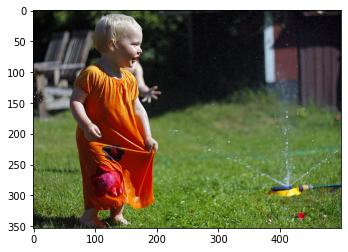

Greedy: young boy in red shirt is running through the sprinklers
Beam Search(k=3): little boy in red shirt runs through the grass
Beam Search:(k=5) little boy in red shirt runs through the grass
Tags : {'little', 'boy', 'shirt', 'red', 'grass', 'runs'}


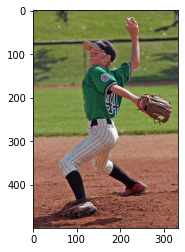

Greedy: baseball player in red and white uniform is throwing the ball
Beam Search(k=3): baseball player in red and white uniform is throwing the ball
Beam Search:(k=5) baseball player hits the ball during game
Tags : {'baseball', 'throwing', 'uniform', 'red', 'white', 'player', 'ball'}


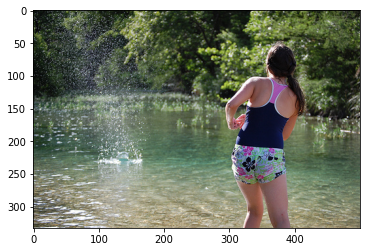

Greedy: young girl in pink bathing suit is jumping into the water
Beam Search(k=3): little girl in pink bathing suit jumps into the water
Beam Search:(k=5) little girl in pink bathing suit jumps into the water
Tags : {'little', 'bathing', 'suit', 'girl', 'water', 'jumps', 'pink'}


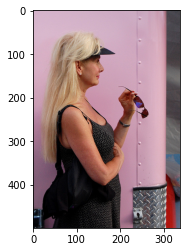

Greedy: man in black shirt is sitting on bench next to woman in white shirt
Beam Search(k=3): the man is wearing black shirt and is sitting on bench next to woman
Beam Search:(k=5) the man in the white shirt is sitting on bench next to woman
Tags : {'next', 'sitting', 'shirt', 'man', 'black', 'woman', 'wearing', 'bench'}


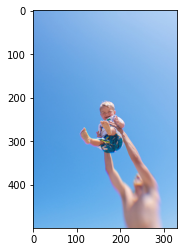

Greedy: boy in red shirt is jumping into the air while another boy watches
Beam Search(k=3): young boy in red shirt is playing in the sand
Beam Search:(k=5) young boy jumps into the air to catch frisbee
Tags : {'playing', 'sand', 'boy', 'shirt', 'young', 'red'}


In [ ]:
for pic,val in encoding_test.items():
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(image))
  bsp=beam_search_predictions(image,3)
  print("Beam Search(k=3):",bsp)
  print("Beam Search:(k=5)",beam_search_predictions(image,5))
  print("Tags : "+str(filter(bsp)))
  # print(filter(bsp))

<h2>Refrences:</h2>
https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
<br>https://nlp.stanford.edu/projects/glove/<br>https://www.kaggle.com/shadabhussain/flickr8k<br>https://github.com/yashk2810/Image-Captioning/blob/master/Image%20Captioning%20InceptionV3.ipynb<br>https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8
